In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import sklearn.linear_model as lm
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')

from sklearn.model_selection import cross_val_score
from scipy import stats
from scipy.stats import norm, skew #for some statistics

pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points

### Load the dataset as dataframes

In [2]:
# Import the dataset and put it in pandas dataframe
df = pd.read_csv("Houston_Data.csv")
print("The size of df is: {}".format(df.shape))

The size of df is: (52759, 90)


In [3]:
# Delete the students with Grade = -1, 0, 1, 2
df = df.drop(df[(df["Grade_1718"] >= -1).multiply(df["Grade_1718"] <= 2)].index)
# Delete the students with Grade = 9, 10, 11, 12 because they are taking EOC instead of reading tests in STAAR
df = df.drop(df[(df["Grade_1718"] >= 9).multiply(df["Grade_1718"] <= 12)].index)

In [4]:
# Save the 'Id' column
df_id = df["Student_GUID"]

In [5]:
# Extract the desired features and labels 
df_demographics = df[["IL.School", "Grade_1718", "Gender", "ELL_1718", "SPED_1718", "Ethnicity", "Attendance.Rate_1718"]]
df_usage = pd.concat([df["Total_Minutes"], df.iloc[:, 29:]], axis = 1)
df_Benchmark = pd.concat([df.iloc[:, 10:12], df.iloc[:, 13:15], df.iloc[:, 16:18]], axis=1)
df_STAAR_1617 = df["Reading.Scale.Score_1617"]
df_STAAR_1718 = df["Reading.Scale.Score_1718"]

In [6]:
# Impute the missing data in usage columns with 0. We assume the missing is due to no usage.
df_usage = df_usage.fillna(0)

In [7]:
# Bring them all together
data = pd.concat([df_demographics, df_Benchmark, df_STAAR_1718], axis = 1)
print("The size of data is: {}".format(data.shape))

The size of data is: (28594, 14)


# PART I: DATA PREPROCESSING

### Replace "---" with "NaN"

In [8]:
data = data.replace('---', np.nan)

## Data statistics

In [9]:
print(data.dtypes)

IL.School                        object
Grade_1718                        int64
Gender                          float64
ELL_1718                        float64
SPED_1718                       float64
Ethnicity                        object
Attendance.Rate_1718            float64
Benchmark_Literacy_BOY_Score    float64
Benchmark_Vocab_BOY_Score       float64
Benchmark_Literacy_MOY_Score    float64
Benchmark_Vocab_MOY_Score       float64
Benchmark_Literacy_EOY_Score    float64
Benchmark_Vocab_EOY_Score       float64
Reading.Scale.Score_1718        float64
dtype: object


## Feature engineering

### Missing data

In [10]:
# Missing data for data
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio (%)' :data_na})
missing_data

,Missing Ratio (%)
Benchmark_Vocab_EOY_Score,73.823
Benchmark_Literacy_EOY_Score,65.045
Benchmark_Vocab_BOY_Score,61.793
Benchmark_Literacy_BOY_Score,61.793
Benchmark_Vocab_MOY_Score,46.429
Benchmark_Literacy_MOY_Score,40.578
Reading.Scale.Score_1718,6.386
Attendance.Rate_1718,0.112
Ethnicity,0.045
SPED_1718,0.045


In [11]:
# Delete rows (student samples) without STAAR test score (Reading.Scale.Score_1718), 
# since the missing ratio of this is only 8.744%
# Delete rows without Ethnicity, because it is impossible to impute it and the missing ratio is very small (0.003%)
data = data.dropna(subset = ["Reading.Scale.Score_1718", "Ethnicity"])
print("The size of data is: {}".format(data.shape))

The size of data is: (26767, 14)


#### Check the remaining missing values

In [12]:
# Missing data for data
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)
missing_data = pd.DataFrame({'Missing Ratio (%)' :data_na})
missing_data

,Missing Ratio (%)
Benchmark_Vocab_EOY_Score,72.791
Benchmark_Literacy_EOY_Score,63.455
Benchmark_Vocab_BOY_Score,61.957
Benchmark_Literacy_BOY_Score,61.957
Benchmark_Vocab_MOY_Score,45.283
Benchmark_Literacy_MOY_Score,39.171


Imputation is not implemented.

### Getting dummy categorical features (ONE-HOT VECTOR REPRESENTATION)

In [13]:
# get_dummies only convert object (data type) to one-hot vectors, so far it is just for school_district
data = pd.get_dummies(data)
print("The size of data is: {}".format(data.shape))

The size of data is: (26767, 132)


### Feature normalization

In [14]:
# Normalize the target labels only so that outcome across different imputation methods may be compared
from sklearn import preprocessing
array = data["Reading.Scale.Score_1718"].values.reshape(-1, 1)
scaler = preprocessing.StandardScaler().fit(array)
data["Reading.Scale.Score_1718"] = scaler.transform(array)

mu = scaler.mean_
sigma = scaler.scale_
print("Target mean is {}. Target standard deviation is {}".format(mu, sigma))

Target mean is [1464.54630702]. Target standard deviation is [147.59229586]


## Getting the new training and test sets

In [15]:
# Split features and labels
X = data.drop(["Reading.Scale.Score_1718"], axis=1).values
y = data["Reading.Scale.Score_1718"].values
# Split the training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

Note: the training and test datasets are now numpy arrays instead of pandas dataframe 

# PART II: Machine Learning Models

In [16]:
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

### Define a cross validation strategy and other helper functions
We use the cross_val_score function of Sklearn. However this function has not a shuffle attribute, we add then one line of code, in order to shuffle the dataset prior to cross-validation

In [17]:
#Validation function
n_folds = 5
def rmsne_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=1).get_n_splits(X_train)
    rmsne= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmsne)

In [18]:
# transform the target lables back to the original scale
def restore(y):
    return (y * sigma) + mu
# root mean square nomalization error
def rmsne(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

## Base models

### 1. Xgboost

In [19]:
XGBR = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)
score = rmsne_cv(XGBR)
print("CV score: {:.4f} ({:.4f}) ".format(score.mean(), score.std()))

CV score: 0.6836 (0.0161) 


### 2. LightGBM

In [20]:
LGBM = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)
score = rmsne_cv(LGBM)
print("CV score: {:.4f} ({:.4f}) ".format(score.mean(), score.std()))

CV score: 0.6992 (0.0168) 


### 3. Stacking models

- Simplest Stacking approach : Averaging base models

We begin with this simple approach of averaging base models. We build a new class to extend scikit-learn with our model and also to laverage encapsulation and code reuse (inheritance)

In [21]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1) 

Averaged base models score: We just average four models here ENet, GBoost, KRR and lasso. Of course we could easily add more models in the mix.

In [22]:
averaged_models = AveragingModels(models = (XGBR, LGBM))

score = rmsne_cv(averaged_models)
print("CV score: {:.4f} ({:.4f}) ".format(score.mean(), score.std()))

CV score: 0.6868 (0.0166) 


- __Stacking averaged Models Class (Less simple Stacking : Adding a Meta-model)__

In [23]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [24]:
Ridge = linear_model.Ridge(alpha = 0.5)
stacked_averaged_models = StackingAveragedModels(base_models = (LGBM, XGBR), meta_model = Ridge)

score = rmsne_cv(stacked_averaged_models)
print("CV score: {:.4f} ({:.4f}) ".format(score.mean(), score.std()))

CV score: 0.6833 (0.0166) 


### 4. Ensembling StackedRegressor, XGBoost and LightGBM

We add XGBoost and LightGBM to the StackedRegressor defined previously

__Final Training and Prediction__


In [25]:
# StackedRegressor
STACK = stacked_averaged_models.fit(X_train, y_train)
stacked_pred = STACK.predict(X_test)
print("Model score on the test set: {:.4f}".format(rmsne(y_test, stacked_pred)))

Model score on the test set: 0.6773


In [26]:
# XGBoost
XGBR = XGBR.fit(X_train, y_train)
xgb_pred = XGBR.predict(X_test)
print("Model score on the test set: {:.4f}".format(rmsne(y_test, xgb_pred)))

Model score on the test set: 0.6783


In [27]:
# LightGBM
LGBM = LGBM.fit(X_train, y_train)
lgb_pred = LGBM.predict(X_test)
print("Model score on the test set: {:.4f}".format(rmsne(y_test, lgb_pred)))

Model score on the test set: 0.6950


In [28]:
# Emsemble prediction
ensemble = stacked_pred*0.60 + xgb_pred*0.20 + lgb_pred*0.20
print("Model score on the test set: {:.4f}".format(rmsne(y_test, ensemble)))

Model score on the test set: 0.6786


In [29]:
# transform the target lables and predictions back to the original scale
y_pred_restored = restore(ensemble)
y_test_restored = restore(y_test)

# PART III: Visualization of the prediction results

In [30]:
# Table visualization
per_error = (np.absolute(y_pred_restored - y_test_restored) / y_test_restored) * 100
chart = pd.DataFrame()
chart["True score"] = y_test_restored
chart["Predicted score"] = y_pred_restored
chart["Percentage error (%)"] = per_error
chart = chart.sort_index()
chart.describe()

,True score,Predicted score,Percentage error (%)
count,5354.000,5354.000,5354.000
mean,1467.573,1466.341,5.227
std,146.752,106.254,4.377
min,850.000,1171.438,0.000
25%,1362.000,1390.077,1.945
50%,1462.000,1467.975,4.138
75%,1562.000,1541.498,7.429
max,2017.000,1817.134,55.501


Alternative performance measure: $E = \dfrac{||True - Predicted||^2}{||True||^2}$ or $E = \dfrac{||True - Predicted||}{||True||}$. 
Good single value performance measure but can't be applied interval estimate.

In [31]:
np.absolute(y_pred_restored - y_test_restored).sum() / np.absolute(y_test_restored).sum() *100

5.213046956110954

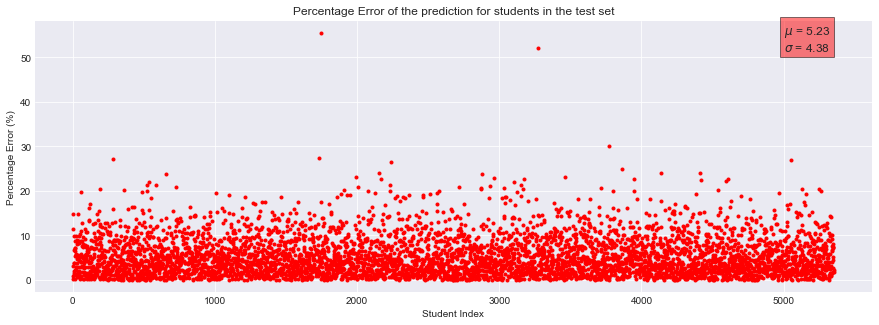

In [32]:
# Draw the percentage error 
plt.figure(figsize=(15,5))
plt.plot(chart["Percentage error (%)"], "r.", label="Percentage error")
plt.xlabel("Student Index")
plt.ylabel("Percentage Error (%)")
#plt.ylim(0, 50)
plt.title("Percentage Error of the prediction for students in the test set")
plt.text(5000, 52,'$\mu$ = {:2.2f}\n$\sigma$ = {:2.2f}'.format(per_error.mean(), per_error.std()), bbox=dict(facecolor="red", alpha=0.5),fontsize=12 )
plt.show()

# PART IV: From regression to classification

- At Risk (Below Grade Level Performance) binary classification

In [33]:
# Create a dataframe A that contains all the necessary info for score-indicator transformation
A = pd.DataFrame()
A["Grade"] = X_test[:,0]
A["y_test"] = y_test_restored
A["y_pred"] = y_pred_restored
A["AtRisk_true"] = pd.Series(np.zeros(len(A)), index=A.index)
A["AtRisk_pred"] = pd.Series(np.zeros(len(A)), index=A.index)

In [34]:
# Map score to classification indicator
for i in range(len(A)):
    if A.iloc[i, 0] == 3: # Grade 
        A.iloc[i, 3] = (A.iloc[i, 1] <= 1345).astype(int)
        A.iloc[i, 4] = (A.iloc[i, 2] <= 1345).astype(int)
    elif A.iloc[i, 0] == 4: # Grade 
        A.iloc[i, 3] = (A.iloc[i, 1] <= 1434).astype(int)
        A.iloc[i, 4] = (A.iloc[i, 2] <= 1434).astype(int)
    elif A.iloc[i, 0] == 5: # Grade 
        A.iloc[i, 3] = (A.iloc[i, 1] <= 1470).astype(int)
        A.iloc[i, 4] = (A.iloc[i, 2] <= 1470).astype(int)
    elif A.iloc[i, 0] == 6: # Grade 
        A.iloc[i, 3] = (A.iloc[i, 1] <= 1517).astype(int)
        A.iloc[i, 4] = (A.iloc[i, 2] <= 1517).astype(int)
    elif A.iloc[i, 0] == 7: # Grade 
        A.iloc[i, 3] = (A.iloc[i, 1] <= 1567).astype(int)
        A.iloc[i, 4] = (A.iloc[i, 2] <= 1567).astype(int)
    elif A.iloc[i, 0] == 8: # Grade 
        A.iloc[i, 3] = (A.iloc[i, 1] <= 1587).astype(int)
        A.iloc[i, 4] = (A.iloc[i, 2] <= 1587).astype(int)

In [35]:
A.describe()

,Grade,y_test,y_pred,AtRisk_true,AtRisk_pred
count,5354.000,5354.000,5354.000,5354.000,5354.000
mean,4.770,1467.573,1466.341,0.512,0.455
std,1.550,146.752,106.254,0.500,0.498
min,3.000,850.000,1171.438,0.000,0.000
25%,4.000,1362.000,1390.077,0.000,0.000
50%,5.000,1462.000,1467.975,1.000,0.000
75%,6.000,1562.000,1541.498,1.000,1.000
max,8.000,2017.000,1817.134,1.000,1.000


In [36]:
from sklearn.metrics import accuracy_score
print("Below grade level performance classification:")
print("The baseline for classification accuracy is {:2.2%}".format(A["AtRisk_true"].sum()/len(A["AtRisk_true"])))
print("The test classification accuracy is {:2.2%}".format(accuracy_score(A["AtRisk_true"], A["AtRisk_pred"])))

Below grade level performance classification:
The baseline for classification accuracy is 51.16%
The test classification accuracy is 75.05%


## Analysis by grade level

### By-grade mean

In [37]:
# pred mean
pred_mean_grades = []
for i in range(3,9):
    pred_mean = A[A["Grade"] == i]["y_pred"].mean()
    pred_mean_grades.append(pred_mean)
    print("The predicted mean score for grade {} is: {:.4}".format(i, format(pred_mean,"f")))

The predicted mean score for grade 3 is: 1381
The predicted mean score for grade 4 is: 1445
The predicted mean score for grade 5 is: 1509
The predicted mean score for grade 6 is: 1472
The predicted mean score for grade 7 is: 1539
The predicted mean score for grade 8 is: 1573


In [38]:
# true mean
true_mean_grades = []
for i in range(3,9):
    true_mean = A[A["Grade"] == i]["y_test"].mean()
    true_mean_grades.append(true_mean)
    print("The true mean score for grade {} is: {:.4}".format(i, format(true_mean, "f")))

The true mean score for grade 3 is: 1382
The true mean score for grade 4 is: 1445
The true mean score for grade 5 is: 1514
The true mean score for grade 6 is: 1466
The true mean score for grade 7 is: 1540
The true mean score for grade 8 is: 1578


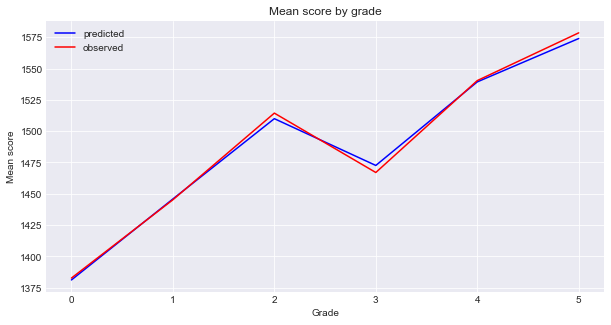

In [39]:
plt.figure(figsize=(10,5))
plt.plot(pred_mean_grades, "b", label="predicted")
plt.plot(true_mean_grades, "r", label="observed")
plt.xlabel("Grade")
plt.ylabel("Mean score")
plt.title("Mean score by grade")
plt.legend()
plt.show()

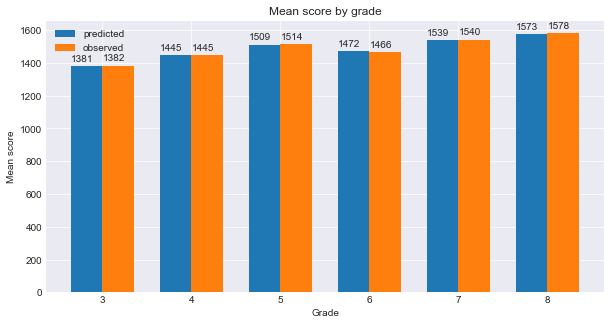

In [40]:
## fig, ax = plt.subplots()
plt.figure(figsize=(10,5))
bar_width = 0.35
opacity = 0.8

ind = np.arange(3,9)
plt.bar(ind-0.5*bar_width, pred_mean_grades, bar_width, label="predicted")
plt.bar(ind+0.5*bar_width, true_mean_grades, bar_width, label="observed")
plt.xlabel("Grade")
plt.ylabel("Mean score")
plt.title("Mean score by grade")
plt.legend()

for i in ind:
    plt.text(x=i-bar_width, y=pred_mean_grades[i-3]+30, s=int(pred_mean_grades[i-3]))
    plt.text(x=i, y=true_mean_grades[i-3]+30, s=int(true_mean_grades[i-3]))
plt.show()

### By-grade regression loss/error

In [41]:
errors_grades = []
for i in range(3,9):
    error = np.sqrt(mean_squared_error(np.log(A[A["Grade"] == i]["y_test"]), np.log(A[A["Grade"] == i]["y_pred"])))
    errors_grades.append(error)
    print("The regression loss/error for grade {} is: {:.4}".format(i, error))

The regression loss/error for grade 3 is: 0.07516
The regression loss/error for grade 4 is: 0.07251
The regression loss/error for grade 5 is: 0.065
The regression loss/error for grade 6 is: 0.06229
The regression loss/error for grade 7 is: 0.05486
The regression loss/error for grade 8 is: 0.05656


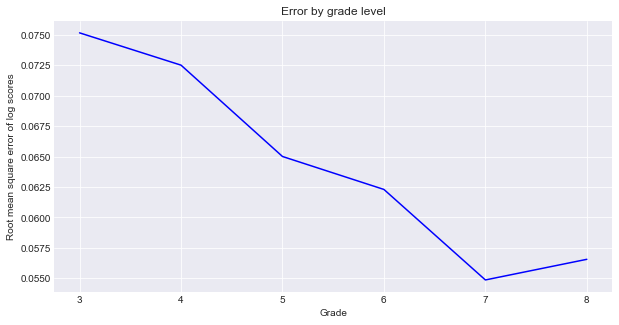

In [42]:
plt.figure(figsize=(10,5))
plt.plot(range(3,9), errors_grades, "b", label="rmsle by grade")
plt.xlabel("Grade")
plt.ylabel("Root mean square error of log scores")
#plt.ylim(0,0.1)
plt.title("Error by grade level")
plt.show()

### By-grade classification accuracy

In [43]:
accuracies_grades = []
for i in range(3,9):
    accuracy = accuracy_score(A[A["Grade"] == i]["AtRisk_true"], A[A["Grade"] == i]["AtRisk_pred"])
    accuracies_grades.append(accuracy)
    print("The classification accuracy for grade {} is: {:2.2%}".format(i, accuracy))

The classification accuracy for grade 3 is: 75.60%
The classification accuracy for grade 4 is: 73.48%
The classification accuracy for grade 5 is: 76.96%
The classification accuracy for grade 6 is: 77.43%
The classification accuracy for grade 7 is: 74.70%
The classification accuracy for grade 8 is: 70.46%


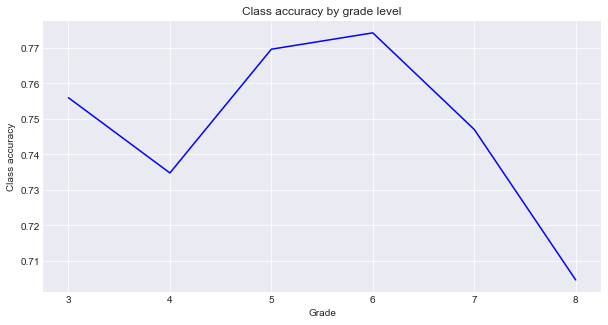

In [44]:
plt.figure(figsize=(10,5))
plt.plot(range(3,9), accuracies_grades, "b", label="accuracy by grade")
plt.xlabel("Grade")
plt.ylabel("Class accuracy")
#plt.ylim(0.7,0.9)
plt.title("Class accuracy by grade level")
plt.show()